## Example: Hierarchical Gaussian Filter

In this demo the goal is to perform approximate variational Bayesian Inference for Univariate Hierarchical Gaussian Filter (HGF).

Simple HGF model can be defined as:

$$
\begin{equation}
  \begin{aligned}
    x^{(j)}_k & \sim \, \mathcal{N}(x^{(j)}_{k - 1}, f_k(x^{(j - 1)}_k)) \\
    y_k & \sim \, \mathcal{N}(x^{(j)}_k, \tau_k)
  \end{aligned}
\end{equation}
$$

where $j$ is an index of layer in hierarchy, $k$ is a time step and $f_k$ is a variance activation function. `ReactiveMP.jl` export Gaussian Controlled Variance (GCV) node with $f_k = \exp(\kappa x + \omega)$ variance activation function. By default uses Gauss-Hermite cubature with a prespecified number of approximation points in the cubature. We can change the number of points in Gauss-Hermite cubature with the help of metadata structures in `ReactiveMP.jl`. 

$$
\begin{equation}
  \begin{aligned}
    z_k & \sim \, \mathcal{N}(z_{k - 1}, \mathcal{\tau_z}) \\
    x_k & \sim \, \mathcal{N}(x_{k - 1}, \exp(\kappa z_k + \omega)) \\
    y_k & \sim \, \mathcal{N}(x_k, \mathcal{\tau_y})
  \end{aligned}
\end{equation}
$$

In this experiment we will create a single time step of the graph and perform variational message passing filtering alrogithm to estimate hidden states of the system. For a more rigorous introduction to Hierarchical Gaussian Filter we refer to [Ismail Senoz, Online Message Passing-based Inference in the Hierarchical Gaussian Filter](https://ieeexplore.ieee.org/document/9173980) paper.

For simplicity we will consider $\tau_z$, $\tau_y$, $\kappa$ and $\omega$ known and fixed.

To model this process in `ReactiveMP`, first, we start with importing all needed packages:

In [1]:
using Rocket, ReactiveMP, GraphPPL, Distributions
using BenchmarkTools, Random, Plots

Next step, is to generate some synthetic data:

In [2]:
function generate_data(rng, k, w, zv, yv)
    z_prev = 0.0
    x_prev = 0.0

    z = Vector{Float64}(undef, n)
    v = Vector{Float64}(undef, n)
    x = Vector{Float64}(undef, n)
    y = Vector{Float64}(undef, n)

    for i in 1:n
        z[i] = rand(rng, Normal(z_prev, sqrt(zv)))
        v[i] = exp(k * z[i] + w)
        x[i] = rand(rng, Normal(x_prev, sqrt(v[i])))
        y[i] = rand(rng, Normal(x[i], sqrt(yv)))

        z_prev = z[i]
        x_prev = x[i]
    end 
    
    return z, x, y
end

generate_data (generic function with 1 method)

In [3]:
# Seed for reproducibility
seed = 123

rng = MersenneTwister(seed)

# Parameters of HGF process
real_k = 1.0
real_w = 0.0
z_variance = abs2(0.5)
y_variance = abs2(1.0)

# Number of observations
n = 300

z, x, y = generate_data(rng, real_k, real_w, z_variance, y_variance);

Lets plot our synthetic dataset. Lines represent our hidden states we want to estimate using noisy observations.

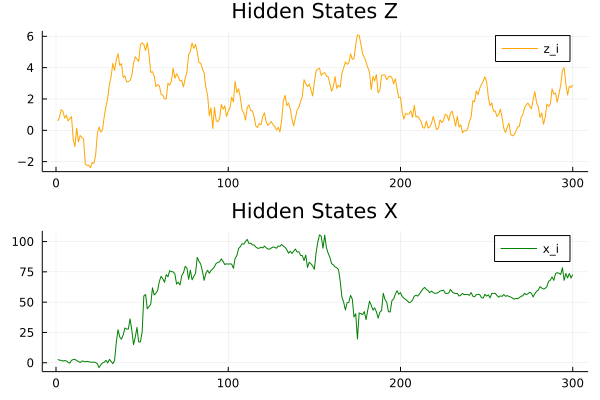

In [4]:
let 
    pz = plot(title = "Hidden States Z")
    px = plot(title = "Hidden States X")
    
    plot!(pz, 1:n, z, label = "z_i", color = :orange)
    plot!(px, 1:n, x, label = "x_i", color = :green)
    
    plot(pz, px, layout = @layout([ a; b ]))
end

To create a model we use `GraphPPL` package and `@model` macro:

In [5]:
# We create a single-time step of corresponding state-space process to
# perform online learning (filtering)
@model [ default_factorisation = MeanField() ] function hgf(real_k, real_w, z_variance, y_variance)
    
    # Priors from previous time step for `z`
    zt_min_mean = datavar(Float64)
    zt_min_var  = datavar(Float64)
    
    # Priors from previous time step for `x`
    xt_min_mean = datavar(Float64)
    xt_min_var  = datavar(Float64)

    zt_min ~ NormalMeanVariance(zt_min_mean, zt_min_var)
    xt_min ~ NormalMeanVariance(xt_min_mean, xt_min_var)

    # Higher layer is modelled as a random walk 
    zt ~ NormalMeanVariance(zt_min, z_variance) where { q = q(zt, zt_min)q(z_variance) }
    
    # Lower layer is modelled with `GCV` node
    gcv_node, xt ~ GCV(xt_min, zt, real_k, real_w) where { q = q(xt, xt_min)q(zt)q(κ)q(ω) }
    
    # Noisy observations 
    y = datavar(Float64)
    y ~ NormalMeanVariance(xt, y_variance)
    
    return zt, xt, y, gcv_node, xt_min_mean, xt_min_var, zt_min_mean, zt_min_var
end

In [42]:
function inference_(data, vmp_iters, real_k, real_w, z_variance, y_variance)
    n = length(data)
    
    # We don't want to save all marginals from all VMP iterations
    # but only last one after all VMP iterations per time step
    # Rocket.jl exports PendingScheduler() object that postpones 
    # any update unless manual `resolve!()` has been called
#     ms_scheduler = PendingScheduler()
    
    mz = keep(Marginal)
    mx = keep(Marginal)
    fe = ScoreActor(Float64)

    model, (zt, xt, y, gcv_node, xt_min_mean, xt_min_var, zt_min_mean, zt_min_var) = hgf(real_k, real_w, z_variance, y_variance)

    # Initial priors
    current_zt_mean, current_zt_var = 0.0, 10.0
    current_xt_mean, current_xt_var = 0.0, 10.0
    
    s_mz = subscribe!(getmarginal(zt), mz)
    s_mx = subscribe!(getmarginal(xt), mx)
    s_fe = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)

    # Initial marginals to start VMP procedire
    setmarginal!(gcv_node, :y_x, MvNormalMeanCovariance([ 0.0, 0.0 ], [ 5.0, 5.0 ]))
    setmarginal!(gcv_node, :z, NormalMeanVariance(0.0, 5.0))
    
    # For each observations we perofrm `vmp_iters` VMP iterations
    for i in 1:n
        
        for _ in 1:vmp_iters
            update!(y, data)
            update!(zt_min_mean, current_zt_mean)
            update!(zt_min_var, current_zt_var)
            update!(xt_min_mean, current_xt_mean)
            update!(xt_min_var, current_xt_var)
        end
        
        # After all VMP iterations we release! `PendingScheduler`
        # as well as release! `ScoreActor` to indicate new time step
#         release!(ms_scheduler)
        release!(fe)
        
        current_zt_mean, current_zt_var = mean_var(last(mz))::Tuple{Float64, Float64}
        current_xt_mean, current_xt_var = mean_var(last(mx))::Tuple{Float64, Float64}
    end
    
    # It is important to unsubscribe at the end of the inference procedure
#     unsubscribe!((s_mz, s_mx, s_fe))
    
    return map(getvalues, (mz, mx, fe))
end

inference_ (generic function with 1 method)

To run inference we also specify number of VMP iterations we want to perform as well as an approximation method for GCV node:

In [43]:
vmp_iters = 10

10

In [44]:
mz, mx, fe = inference_(y, vmp_iters, real_k, real_w, z_variance, y_variance);

In [45]:
let 
    pz = plot(title = "Hidden States Z")
    px = plot(title = "Hidden States X")
    
    plot!(pz, 1:n, z, label = "z_i", color = :orange)
    plot!(pz, 1:n, mean.(mz), ribbon = std.(mz), label = "estimated z_i", color = :teal)
    
#     plot!(px, 1:n, x, label = "x_i", color = :green)
#     plot!(px, 1:n, mean.(mx), ribbon = std.(mx), label = "estimated x_i", color = :violet)
    
#     plot(pz, px, layout = @layout([ a; b ]))
end

BoundsError: BoundsError: attempt to access 300-element UnitRange{Int64} at index [1:3000]

As we can see from our plot, estimated signal resembles closely to the real hidden states with small variance. We maybe also interested in the values for Bethe Free Energy functional:

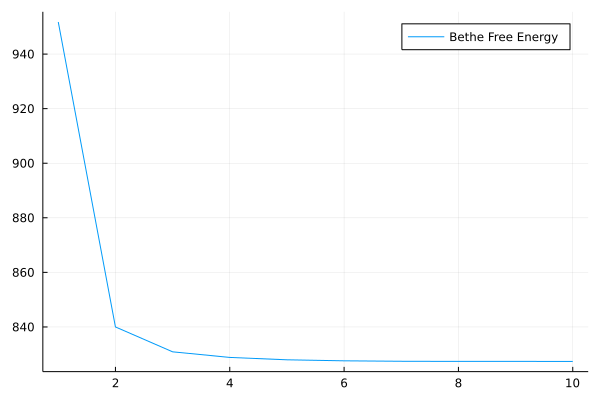

In [10]:
plot(fe, label = "Bethe Free Energy")

As we can see BetheFreeEnergy converges nicely to a stable point.

We may be also interested in performance of our resulting Variational Message Passing algorithm:

In [11]:
@benchmark inference($y, $vmp_iters, $real_k, $real_w, $z_variance, $y_variance)

BenchmarkTools.Trial: 59 samples with 1 evaluation.
 Range (min … max):  73.028 ms … 92.583 ms  ┊ GC (min … max):  0.00% … 10.27%
 Time  (median):     86.755 ms              ┊ GC (median):    10.30%
 Time  (mean ± σ):   84.754 ms ±  5.866 ms  ┊ GC (mean ± σ):   6.92% ±  4.99%

          ▁         ▁       ▄      ▁        ▄▁ ▄  ▁█▄  ▁  ▄ ▄  
  ▆▁▆▆▆▁▆▆█▆▆▁▆▁▁▆▆▁█▁▁▁▁▁▆▁█▆▁▁▁▆▁█▁▆▁▆▁▁▆▆██▆█▁▆███▆▆█▆▆█▁█ ▁
  73 ms           Histogram: frequency by time        92.1 ms <

 Memory estimate: 47.06 MiB, allocs estimate: 788896.